In [1]:
import os
import pandas as pd
from geopy.distance import geodesic
import numpy as np


PROJ_ROOT = os.path.join(os.pardir)

In [2]:
data_path = os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'narr_data.csv')

cols=[0,5,6,12,23,24,28]+list(np.arange(31,70))

all_data=pd.read_csv(data_path, parse_dates=['new_date'])
print(all_data.shape)

C:\Users\Bryan\Anaconda3\envs\hacktb\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,7,8,9,10,11,14,15,16,17,18,19,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(103295, 70)


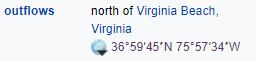

In [3]:
# lat/long of the outflow of the bay
# Taken from https://en.wikipedia.org/wiki/Chesapeake_Bay

OUTFLOW = (36.995833, -75.959444)

In [4]:
def calc_distance(row):
    """ Function to calculate the geodesic distance between two coordinates in miles"""
    # geodesic distance https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid
    
    coords = (row["Latitude"],row["Longitude"])
    
    distance = geodesic(OUTFLOW, coords).miles
    
    return distance

In [5]:
# calculate the distance of all points in the dataset
all_data['of_dist']=all_data.apply(calc_distance,axis=1)

Take a look at correlations of land cover, weather data and this new feature

In [6]:
df=all_data.drop(columns=['DO','TP'],axis=1)
df=all_data[all_data.TN<=200]

In [7]:
all_data.columns

Index(['new_date', 'CloudCover', 'GaugeHeight', 'GroupCode', 'HUC12',
       'Latitude', 'Longitude', 'Method', 'Other Conditions', 'Rainfall',
       'Rainfall Within 24 Hours', 'Rainfall Within 48 Hours', 'SampleDepth',
       'SampleId', 'Station', 'StationCode', 'StationName',
       'Weather Conditions Day Before Yesterday', 'Weather Conditions Today',
       'Weather Conditions Yesterday', 'WindDirection', 'WindSpeed', 'state',
       'HUC12_', 'HUCNAME_', 'FIPS_', 'COUNTY_', 'STATE_', 'areaacres',
       'states', 'huc12', 'za_mean', 'lc_0', 'lc_11', 'lc_21', 'lc_22',
       'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71',
       'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week',
       'dayofweek', 'hour', 'min', 'quarter', 'DO', 'TN', 'TP', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'preci

In [8]:
# look at correlations within one point in a watershed
df[(df.Longitude==-77.73165) & (df.Latitude==39.45037)].apply(lambda x: x.factorize()[0]).corr().loc['TN'].sort_values(ascending=False).sort_values(ascending=False)[:50]

TN                                         1.000000
humidity_narr                              0.913070
new_date                                   0.912340
SampleId                                   0.912340
airtemp_narr                               0.911902
wdirection_narr                            0.911902
windspeed_narr                             0.911902
v_wind_narr                                0.911902
u_wind_narr                                0.911902
sfc_air_narr                               0.907480
precip48_narr                              0.789445
year                                       0.744154
precip24_narr                              0.648528
TP                                         0.562437
SampleDepth                                0.327282
min                                        0.266289
precip3_narr                               0.251308
Station                                    0.250395
week                                       0.220179
dayofweek   

In [9]:
# take a look at correlations within the whole watershed with the new feature
df.corr(method='pearson').loc['TN'].sort_values(ascending=False)

TN                 1.000000
Latitude           0.323130
TP                 0.314826
lc_82              0.299361
za_mean            0.288621
of_dist            0.279220
lc_81              0.241303
sfc_runoff         0.205471
DO                 0.160686
precip24_narr      0.127300
precip48_narr      0.115038
year               0.111673
dayofweek          0.101916
lc_21              0.087515
Longitude          0.075145
precip3_narr       0.066460
lc_43              0.062946
cl_cover_narr      0.051677
lc_22              0.047297
windspeed_narr     0.038567
lc_23              0.020675
hour               0.019791
lc_41              0.018474
SampleId           0.015548
GaugeHeight        0.015343
lc_24              0.007545
v_wind_narr        0.003573
humidity_narr      0.003130
lc_90              0.002829
wdirection_narr    0.001223
u_wind_narr       -0.001223
lc_31             -0.029494
lc_95             -0.042799
quarter           -0.043011
month             -0.043416
week              -0

Looking at the WHOLE watershed, distance from the outflow (latitude & the new feature of_dist) and land cover data seem to seem to be slightly correlated over the weather data. More data is most likley needed to make accurate predictions for the whole watershed. 

Certain HUC's may need to be removed. Looking at correlations at one point in a watershed, weather conditions are very highly correlated and land cover and location data has no correlation, because the data does not change. Trying to predict for the whole watershed will skew the predictions toward certain HUCs.

Approaches that could be taken
 - Omit the two HUC's that are in the dead center of the bay (lower bay / mid bay) - with no land mass, only water. When looking at the Chesapeake bay map indicators https://ian.umces.edu/ecocheck/report-cards/chesapeake-bay/2012/indicators/total_nitrogen/#_Data_Map These areas are consistently 'Very Good' and will skew the results for the more polluted areas of the bay (areas of more interest)
 - Use classification methods to determine 'poor' areas of the bay, and create a seperate regression models for  'good' and 'poor' areas of the bay.
 - Join more land cover data for more years to determine if the change in the land cover is changing the pollutant levels. Land cover for only one year is a snapshot and will not determine pollutant correlations (as seen from the very low correlation levels within the whole watershed, and No correlation for within one point in the watershed)

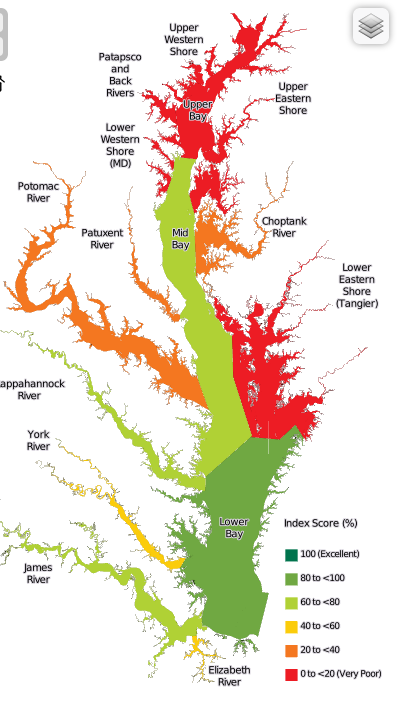 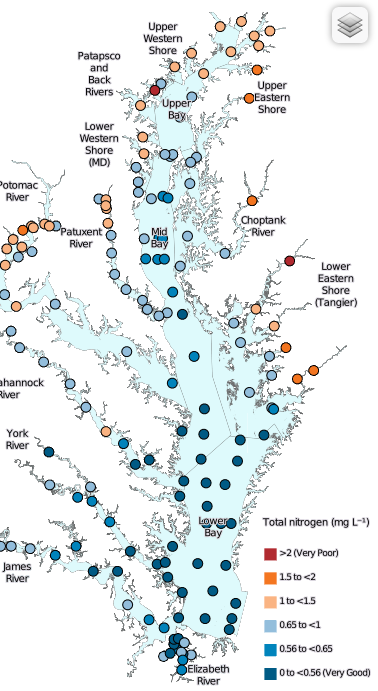

In [10]:
data_2 = os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'dfnitro3.csv')


In [11]:

new_data=pd.read_csv(data_2)
print(new_data.shape)

(67040, 55)


In [12]:
new_data['of_dist']=new_data.apply(calc_distance,axis=1)

In [13]:
data_2 = os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'model_data_v2.csv')
new_data.to_csv(data_2,index=False)